# Predicting Shelter Animal Outcomes

The goal of this project is to predict the outcome of shelter animals given a dataset containing outcome information including breed, color, sex and age. This is a [past Kaggle competition](https://www.kaggle.com/c/shelter-animal-outcomes) with data from [Austin Animal Center](http://www.austintexas.gov/department/animal-services) from October 1st, 2013 to March, 2016. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz

/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data = pd.read_csv("train.csv")
print(data.shape)
print(data.dtypes)

(26729, 10)
AnimalID          object
Name              object
DateTime          object
OutcomeType       object
OutcomeSubtype    object
AnimalType        object
SexuponOutcome    object
AgeuponOutcome    object
Breed             object
Color             object
dtype: object


In [3]:
data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [4]:
data.OutcomeType.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

In [5]:
data.isnull().sum()

AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

## 1. Formatting and Analyzing Individual Features
Before I start predicting outcomes, I need to format features to be suitable for analyses and see their individual relationship to the outcomes. 

### a. Animal Type

In [6]:
AnimalTypeGroup = data.groupby('AnimalType')
print(AnimalTypeGroup.AnimalType.value_counts())
AnimalTypeGroup.OutcomeType.value_counts() 

AnimalType  AnimalType
Cat         Cat           11134
Dog         Dog           15595
Name: AnimalType, dtype: int64


AnimalType  OutcomeType    
Cat         Transfer           5505
            Adoption           4272
            Euthanasia          710
            Return_to_owner     500
            Died                147
Dog         Adoption           6497
            Return_to_owner    4286
            Transfer           3917
            Euthanasia          845
            Died                 50
Name: OutcomeType, dtype: int64

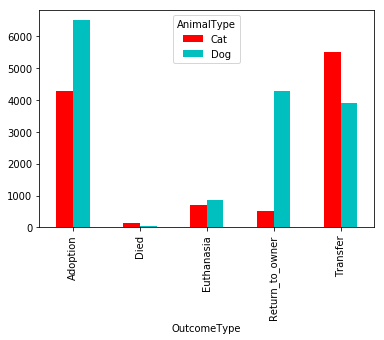

In [7]:
AnimalTypeGraph = data[['AnimalType','OutcomeType']].groupby(['OutcomeType','AnimalType']).size().unstack()
AnimalTypeGraph.plot(kind='bar',color=['r','c'])

### b. DateTime

In [8]:
#format Datetime
data['DateTime'] = pd.to_datetime(data['DateTime'])

In [9]:
data['Hour'] = data.DateTime.dt.hour

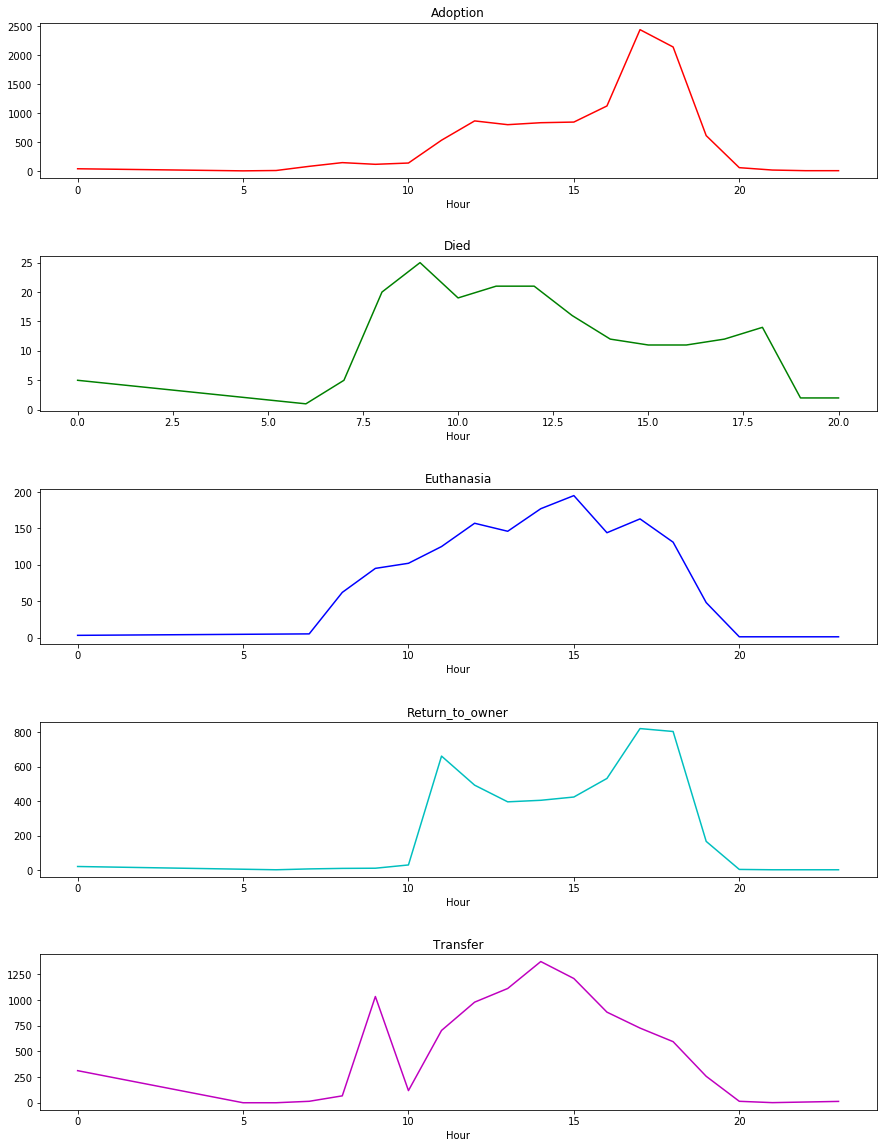

In [10]:
# Outcomes by Hour
hourGroup=data.Hour.groupby(data.OutcomeType)
plt.subplots(5, 1, figsize=(15, 20), sharex=True)
plt.subplots_adjust( hspace=0.5)
colors = list('rgbcmyk')
for i, (f, g) in enumerate(hourGroup):
    plt.subplot(5,1,i+1)
    plt.title(f)
    g.groupby(data.Hour).count().plot(kind="line", color=colors[i])

In [11]:
data['DoW'] = data.DateTime.dt.dayofweek

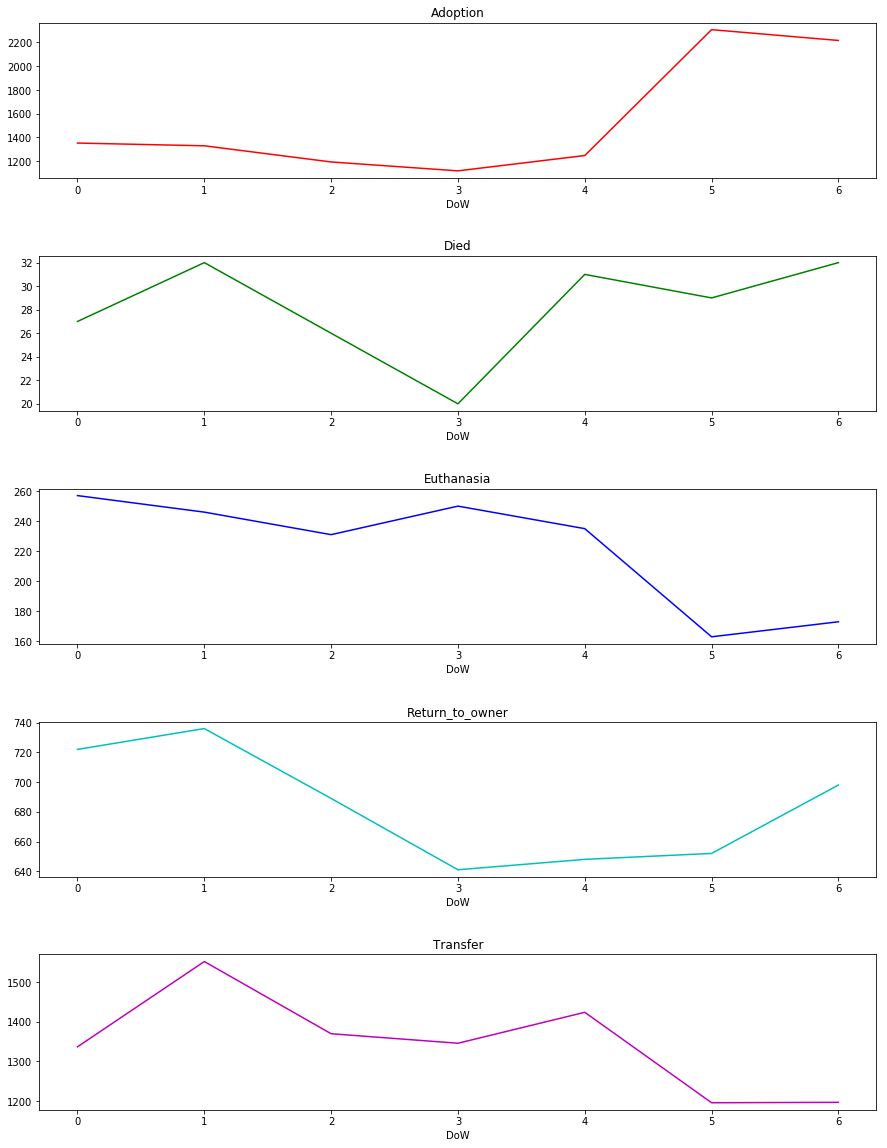

In [12]:
# Outcomes per Week
weekGroup=data.DoW.groupby(data.OutcomeType)
plt.subplots(5, 1, figsize=(15, 20), sharex=True)
plt.subplots_adjust( hspace=0.5)
colors = list('rgbcmyk')
for i, (f, g) in enumerate(weekGroup):
    plt.subplot(5,1,i+1)
    plt.title(f)
    g.groupby(data.DoW).count().plot(kind="line", color=colors[i])

In [13]:
data['Month'] = data.DateTime.dt.month

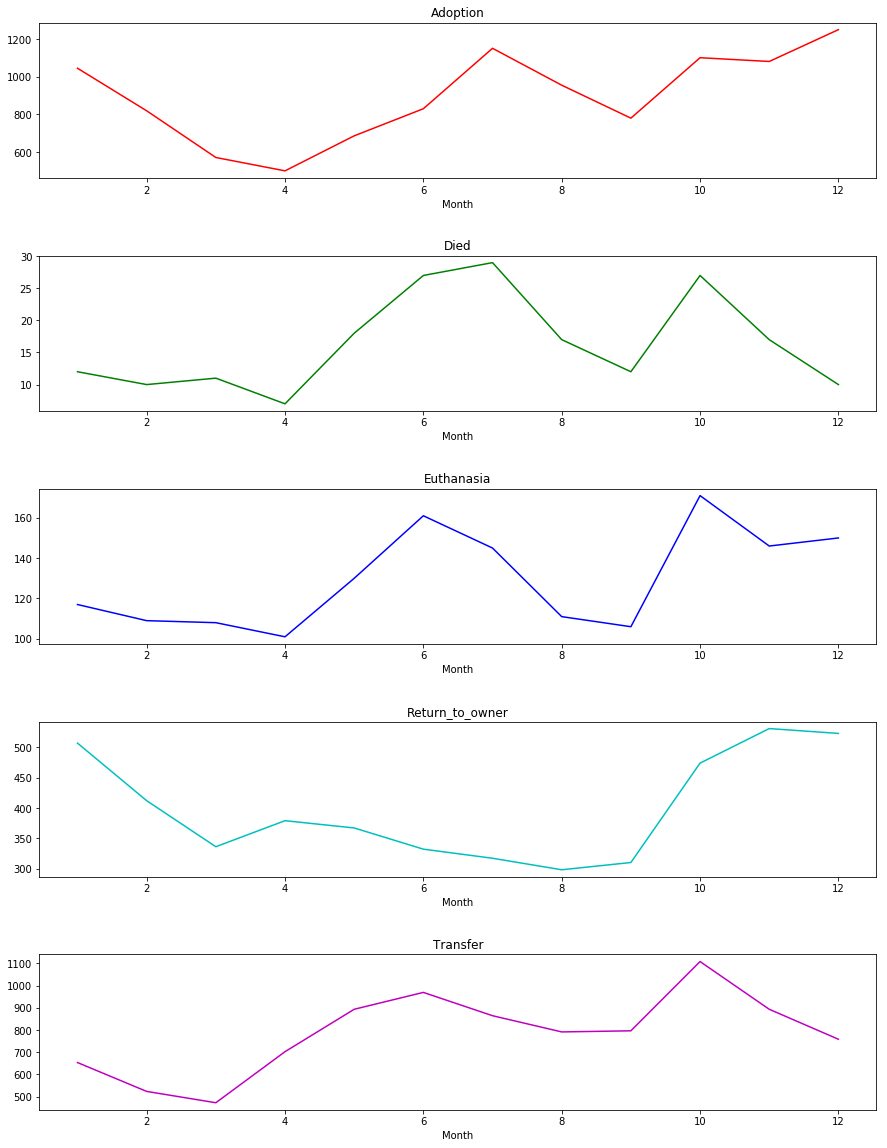

In [14]:
# Outcomes by Month
monthGroup=data.Month.groupby(data.OutcomeType)
plt.subplots(5, 1, figsize=(15, 20), sharex=True)
plt.subplots_adjust(hspace=0.5)
colors = list('rgbcmyk')
for i, (f, g) in enumerate(monthGroup):
    plt.subplot(5,1,i+1)
    plt.title(f)
    g.groupby(data.Month).count().plot(kind="line", color=colors[i])

### c. Age

In [15]:
# create list of age in days
dataAge = data.AgeuponOutcome.tolist()
AgeinDays = []
for i in dataAge:
    try:
        num = (i.split()[0])
        letter = (i.split()[1][0])
        if(letter == 'y'):
            days = int(num)*365
        elif(letter == 'm'):
            days = int(num)*30
        elif(letter == 'w'):
            days = int(num)*7
        else:
            days = int(num)
        AgeinDays.append(days)
    except:
        AgeinDays.append(np.nan)

In [16]:
# append numerical age column to data set
data['AgeinDays'] = AgeinDays

In [19]:
age_median =  data.AgeinDays.median()
data.AgeinDays.fillna(age_median, inplace=True)
print(data.AgeinDays.isnull().sum())

0


In [20]:
# Break age into baby(0-6 months), puppy(6-18 months), adult (18 - inf)
data['Lifestage'] = pd.cut(data.AgeinDays,[-1,180,365,np.inf])
data.Lifestage.value_counts()

(365.0, inf]      10852
(-1.0, 180.0]     10353
(180.0, 365.0]     5524
Name: Lifestage, dtype: int64

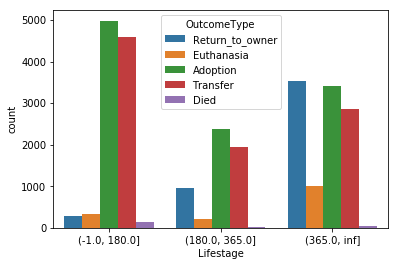

In [21]:
sns.countplot(data = data, x='Lifestage', hue='OutcomeType')

In [22]:
del data['AgeuponOutcome']
data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,Breed,Color,Hour,DoW,Month,AgeinDays,Lifestage
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,Shetland Sheepdog Mix,Brown/White,18,2,2,365.0,"(180.0, 365.0]"
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,Domestic Shorthair Mix,Cream Tabby,12,6,10,365.0,"(180.0, 365.0]"
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,Pit Bull Mix,Blue/White,12,5,1,730.0,"(365.0, inf]"
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,Domestic Shorthair Mix,Blue Cream,19,4,7,21.0,"(-1.0, 180.0]"
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,Lhasa Apso/Miniature Poodle,Tan,12,4,11,730.0,"(365.0, inf]"


### d. Breed Data

In [23]:
data.Breed

0                        Shetland Sheepdog Mix
1                       Domestic Shorthair Mix
2                                 Pit Bull Mix
3                       Domestic Shorthair Mix
4                  Lhasa Apso/Miniature Poodle
5            Cairn Terrier/Chihuahua Shorthair
6                       Domestic Shorthair Mix
7                       Domestic Shorthair Mix
8                American Pit Bull Terrier Mix
9                                Cairn Terrier
10                      Domestic Shorthair Mix
11                     Miniature Schnauzer Mix
12                                Pit Bull Mix
13                       Yorkshire Terrier Mix
14                          Great Pyrenees Mix
15                      Domestic Shorthair Mix
16                      Domestic Shorthair Mix
17                                Pit Bull Mix
18                                  Angora Mix
19                     Flat Coat Retriever Mix
20                       Queensland Heeler Mix
21           

In [24]:
# create column to identify mixed breeds
mixMask = ['Mix' in breed for breed in data.Breed.tolist()]
data['MixedBreed'] = mixMask
data.MixedBreed = data.MixedBreed.astype(int)

In [25]:
# Simplify breed data
data[['FirstBreed',
      'SecondBreed',
      'ThirdBreed']] = data.Breed.str.split("/", expand=True)

In [26]:
BreedData = data.FirstBreed.tolist()
FirstBreedList = []
for breed in BreedData:
    if "Mix" in breed: 
        breed = breed[0:-4]
    FirstBreedList.append(breed)

In [27]:
data['FirstBreed'] = FirstBreedList

In [28]:
print(data.Breed.nunique())
data.FirstBreed.nunique()

1380


220

### e. Color

In [29]:
data.Color

0                Brown/White
1                Cream Tabby
2                 Blue/White
3                 Blue Cream
4                        Tan
5                  Black/Tan
6                 Blue Tabby
7                Brown Tabby
8                  Red/White
9                      White
10                     Black
11                    Silver
12                     Brown
13                 Black/Red
14               White/Cream
15        Orange Tabby/White
16               Brown Tabby
17               Brown/White
18                     White
19                     Black
20               Black/White
21                     White
22       Brown Brindle/White
23               Brown/White
24               Black/Brown
25              Orange Tabby
26           Chocolate/White
27                 White/Tan
28         Cream Tabby/White
29                      Blue
                ...         
26699            White/Black
26700              Tan/Cream
26701            White/Black
26702         

In [30]:
data[['FirstColor','SecondColor']] = data.Color.str.split("/", expand=True)
print(data.FirstColor.nunique())
data.FirstColor.value_counts().sum()

57


26729

### f. Sex and Sterilization

Sex and Sterilization are two distinct features so it makes more sense to separate it into two columns instead of individual dummy columns. 

In [36]:
# Fill missing value
most_frequent = data.SexuponOutcome.value_counts()[0]
data.SexuponOutcome.fillna("Unknown", inplace=True)
data.SexuponOutcome.value_counts()

Neutered Male    9779
Spayed Female    8820
Intact Male      3525
Intact Female    3511
Unknown          1094
Name: SexuponOutcome, dtype: int64

In [37]:
# Separate SexuponOutcome column into Sex and Neutered/Spayed 
# Female = 1 and Intact = 1
sexMask = ['Female' in sex for sex in data.SexuponOutcome.tolist()]
sterileMask = ['Intact' in fix for fix in data.SexuponOutcome.tolist()]

In [38]:
data['Sex'] = sexMask
data['Sterile'] = sterileMask
data.Sex = data.Sex.astype(int)
data.Sterile = data.Sterile.astype(int)

In [39]:
data.Sex.value_counts() 

0    14398
1    12331
Name: Sex, dtype: int64

In [40]:
data.Sterile.value_counts()

0    19693
1     7036
Name: Sterile, dtype: int64

In [41]:
del data['SexuponOutcome']
data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,Breed,Color,Hour,DoW,...,AgeinDays,Lifestage,MixedBreed,FirstBreed,SecondBreed,ThirdBreed,FirstColor,SecondColor,Sex,Sterile
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Shetland Sheepdog Mix,Brown/White,18,2,...,365.0,"(180.0, 365.0]",1,Shetland Sheepdog,None,None,Brown,White,0,0
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Domestic Shorthair Mix,Cream Tabby,12,6,...,365.0,"(180.0, 365.0]",1,Domestic Shorthair,None,None,Cream Tabby,None,1,0
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Pit Bull Mix,Blue/White,12,5,...,730.0,"(365.0, inf]",1,Pit Bull,None,None,Blue,White,0,0
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Domestic Shorthair Mix,Blue Cream,19,4,...,21.0,"(-1.0, 180.0]",1,Domestic Shorthair,None,None,Blue Cream,None,0,1
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Lhasa Apso/Miniature Poodle,Tan,12,4,...,730.0,"(365.0, inf]",0,Lhasa Apso,Miniature Poodle,None,Tan,None,0,0


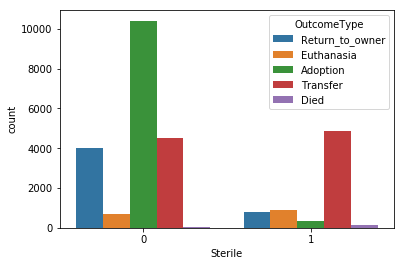

In [42]:
sns.countplot(data = data, x='Sterile', hue='OutcomeType')

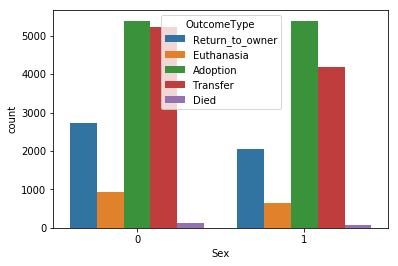

In [43]:
sns.countplot(data = data, x='Sex', hue='OutcomeType')

## Logistic Regression

In [44]:
data.columns.tolist()

['AnimalID',
 'Name',
 'DateTime',
 'OutcomeType',
 'OutcomeSubtype',
 'AnimalType',
 'Breed',
 'Color',
 'Hour',
 'DoW',
 'Month',
 'AgeinDays',
 'Lifestage',
 'MixedBreed',
 'FirstBreed',
 'SecondBreed',
 'ThirdBreed',
 'FirstColor',
 'SecondColor',
 'Sex',
 'Sterile']

In [45]:
# Generate features and target
feature_cols = [
 'AnimalType',
 'Hour',
 'DoW',
 'Month',
 'AgeinDays',
 'Lifestage',
 'MixedBreed',
 'FirstBreed',
 'FirstColor',
 'Sex',
 'Sterile'
 ]
le = LabelEncoder()
encoded_X = data[feature_cols].apply(le.fit_transform)
X = encoded_X
y = le.fit_transform(data.OutcomeType)

In [46]:
# Compute Logistic Regression to Predict Outcome
logreg = LogisticRegression(random_state=1)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3)
logreg.fit(X_train,y_train)
OutcomePredLog = logreg.predict(X_test)
print('Model Accuracy:',metrics.accuracy_score(y_test, OutcomePredLog))

Model Accuracy: 0.6205262501558798


In [47]:
cross_val_scores_log = cross_val_score(logreg,X,y,cv=10,scoring='accuracy')
print("Mean cross validation accuracy:",np.mean(cross_val_scores_log))
print("Std of cross validation accuracy:",np.std(cross_val_scores_log))

Mean cross validation accuracy: 0.6165590861831024
Std of cross validation accuracy: 0.0049293011852523435


In [48]:
list(zip(feature_cols, logreg.coef_[0]))

[('AnimalType', 0.10030362978100363),
 ('Hour', 0.14155062807091529),
 ('DoW', 0.12161052649094321),
 ('Month', 0.011380322343410989),
 ('AgeinDays', 0.027388159253436004),
 ('Lifestage', -0.9728639737140731),
 ('MixedBreed', -0.0911845218040243),
 ('FirstBreed', -0.0009940695193188995),
 ('FirstColor', 0.0004564641965245386),
 ('Sex', 0.45158857792461315),
 ('Sterile', -3.3966985697719507)]

## Random Forest

In [49]:
# Generate Random Forest with 100 trees using train_test_split method
rf100 = RandomForestClassifier(n_estimators=100,random_state=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3)
rf100.fit(X_train, y_train)
y_pred_rf_100 = rf100.predict(X_test)

print("Random Forest Train-Test accuracy:",metrics.accuracy_score(y_test,y_pred_rf_100))

Random Forest Train-Test accuracy: 0.6526998378850231


In [50]:
# random forest with cross validation method
cross_val_scores_100 = cross_val_score(rf100,X,y,cv=10,scoring='accuracy')
print("Mean cv-accuracy:",np.mean(cross_val_scores_100))
print("Std of cv-accuracy:",np.std(cross_val_scores_100))

Mean cv-accuracy: 0.6538223121660227
Std of cv-accuracy: 0.005172076452690497


In [51]:
pd.DataFrame({'feature':feature_cols, 
              'importance':rf100.feature_importances_}).sort_values(by='importance', ascending=False)

,feature,importance
4,AgeinDays,0.175588
1,Hour,0.151887
3,Month,0.130063
7,FirstBreed,0.121944
8,FirstColor,0.110934
10,Sterile,0.107259
2,DoW,0.096158
5,Lifestage,0.035348
9,Sex,0.028433
0,AnimalType,0.023078


### Grid Search on Logistic Regression and Random Forest

In [52]:
from sklearn.model_selection import GridSearchCV

In [ ]:
rf_for_grid = RandomForestClassifier(random_state=1, n_jobs=-1)
estimator_range = range(10,101,10)
feature_range = range(1,len(feature_cols)+1)
param_grid = dict(n_estimators = estimator_range, 
                  max_features = feature_range)
RFgrid = GridSearchCV(rf_for_grid, param_grid, cv=10, scoring='accuracy')
RFgrid.fit(X, y)


In [65]:
rf_for_grid.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [105]:
RFgrid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [107]:
RFgrid.best_score_

0.6543454674697894

In [108]:
RFgrid.best_params_

{'max_features': 5, 'n_estimators': 70}

In [109]:
RFgrid.grid_scores_

/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.62711, std: 0.00663, params: {'max_features': 1, 'n_estimators': 10},
 mean: 0.63908, std: 0.00675, params: {'max_features': 1, 'n_estimators': 20},
 mean: 0.64286, std: 0.00555, params: {'max_features': 1, 'n_estimators': 30},
 mean: 0.64499, std: 0.00599, params: {'max_features': 1, 'n_estimators': 40},
 mean: 0.64481, std: 0.00592, params: {'max_features': 1, 'n_estimators': 50},
 mean: 0.64623, std: 0.00525, params: {'max_features': 1, 'n_estimators': 60},
 mean: 0.64757, std: 0.00513, params: {'max_features': 1, 'n_estimators': 70},
 mean: 0.64828, std: 0.00484, params: {'max_features': 1, 'n_estimators': 80},
 mean: 0.64772, std: 0.00579, params: {'max_features': 1, 'n_estimators': 90},
 mean: 0.64813, std: 0.00535, params: {'max_features': 1, 'n_estimators': 100},
 mean: 0.63167, std: 0.00681, params: {'max_features': 2, 'n_estimators': 10},
 mean: 0.64073, std: 0.00632, params: {'max_features': 2, 'n_estimators': 20},
 mean: 0.64365, std: 0.00563, params: {'max_feature

In [55]:
rf_best = RandomForestClassifier(n_estimators=70, max_features=5, max_depth = 12, random_state=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3)
rf_best.fit(X_train, y_train)
y_pred_prob_rf_best = rf_best.predict_proba(X_test)

print("Mean Accuracy for depth 12:", cross_val_score(rf_best, X, y, scoring='accuracy').mean())

Mean Accuracy for depth 12: 0.6648212879403809


In [56]:
# compute feature importances
pd.DataFrame({'feature':feature_cols, 
              'importance':rf_best.feature_importances_}).sort_values(by='importance', ascending=False)

,feature,importance
4,AgeinDays,0.239404
10,Sterile,0.203978
1,Hour,0.153908
7,FirstBreed,0.075654
2,DoW,0.068169
3,Month,0.066887
5,Lifestage,0.060429
8,FirstColor,0.059507
0,AnimalType,0.041508
9,Sex,0.019904


In [67]:
log_for_grid = LogisticRegression()
param_grid2 = {"penalty":['l1','l2'], 'C':[0.1,1,10,100]}
LogGrid = GridSearchCV(log_for_grid, param_grid2, cv=10, scoring='accuracy')
LogGrid.fit(X, y)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [66]:
log_for_grid.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [69]:
LogGrid.grid_scores_

/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.61716, std: 0.00464, params: {'C': 0.1, 'penalty': 'l1'},
 mean: 0.61551, std: 0.00546, params: {'C': 0.1, 'penalty': 'l2'},
 mean: 0.61705, std: 0.00520, params: {'C': 1, 'penalty': 'l1'},
 mean: 0.61693, std: 0.00524, params: {'C': 1, 'penalty': 'l2'},
 mean: 0.61686, std: 0.00516, params: {'C': 10, 'penalty': 'l1'},
 mean: 0.61708, std: 0.00527, params: {'C': 10, 'penalty': 'l2'},
 mean: 0.61682, std: 0.00533, params: {'C': 100, 'penalty': 'l1'},
 mean: 0.61708, std: 0.00516, params: {'C': 100, 'penalty': 'l2'}]

In [70]:
LogGrid.best_score_

0.6171573945901455

In [71]:
LogGrid.best_params_

{'C': 0.1, 'penalty': 'l1'}

In [57]:
best_log = LogisticRegression(C=0.1, penalty='l1')
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3)
best_log.fit(X_train, y_train)
y_pred_prob_log_best = best_log.predict_proba(X_test)

In [58]:
# beta values of best Logistic Regression Model
betas = best_log.fit(X,y).coef_[0]
best_betas = pd.DataFrame(list(zip(feature_cols,betas)),columns=["features","betas"])
best_betas.sort_values("betas",ascending=False,inplace=True)
best_betas

,features,betas
9,Sex,0.472854
1,Hour,0.139531
2,DoW,0.126136
0,AnimalType,0.099546
4,AgeinDays,0.026325
3,Month,0.006462
8,FirstColor,-0.000310
7,FirstBreed,-0.000966
6,MixedBreed,-0.124133
5,Lifestage,-0.963748


##  Model Evaluation

In [59]:
# test against null accuracy
from sklearn.dummy import DummyClassifier
dumb_model = DummyClassifier(strategy='most_frequent')
cross_val_score(dumb_model,X,y,cv=10).mean()


0.40289585361911984

In [60]:
cross_val_score(rf_best,X,y,cv=10).std()

0.005452074601104163

In [61]:
cross_val_score(best_log,X,y,cv=10).std()

0.004593421164816204

In [62]:
# Confusion Matrix for Outcomes
cm_rf = metrics.confusion_matrix(y_test, y_pred_rf_100)
cm_rf

array([[1484,    5,   48,  520, 1131],
       [  31,    0,    0,   11,   20],
       [ 212,    1,    9,   70,  174],
       [ 683,    1,   25,  233,  541],
       [1308,    2,   56,  474,  980]])

In [ ]:
# calculate AUC for logreg and random forest
print("LogReg model AUC: ",metrics.roc_auc_score(y_test, y_pred_prob_log_best[:,1]))
print("RF model AUC: ",metrics.roc_auc_score(y_test, y_pred_prob_rf_best[:,1]))

## For the future....

- Perform Multiple Correspondence Analysis (MCA), PCA for categorical data
- Look into the confusion matrix and ROC curve/AUC score

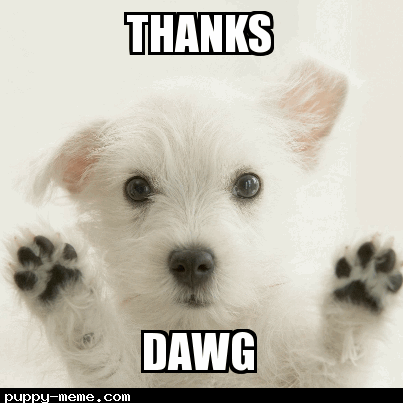